# High-Dimensional Time Series Forecasting with Convolutional Neural Networks: Full-Fledged WaveNet

**Note**: for a written overview on this topic, check out my two blog posts that walk through the core concepts behind WaveNet - [part 1](https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv/), [part 2](https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv2/). 

This notebook expands on the [previous notebook in this series](https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Intro.ipynb), demonstrating in python/keras code how a **convolutional** sequence-to-sequence neural network modeled after WaveNet can be built for the purpose of high-dimensional time series forecasting. I assume working familiarity with **dilated causal convolutions** (WaveNet's core building block), and recommend referencing the 3rd section of the previous notebook if you need to review the concept.

For an introduction to neural network forecasting with an LSTM architecture, check out the [first notebook in this series](https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Intro.ipynb).   

In this notebook I'll be using the daily wikipedia web page traffic dataset again, available [here on Kaggle](https://www.kaggle.com/c/web-traffic-time-series-forecasting/data). The corresponding competition called for forecasting 60 days into the future, which we'll now mirror in this demonstration of a full-fledged model. Once again we'll use all of the series history available in "train_1.csv" for the encoding stage of the model. 

Our goal here is to expand on the previous notebook's simple WaveNet implementation, adding additional architecture components from the [original model](https://arxiv.org/pdf/1609.03499.pdf). In particular, each convolutional block of our network will incorporate **gated activations**, **residual connections**, and **skip connections** in addition to the dilated causal convolutions we saw in the previous notebook. I'll explain how these three new mechanisms work in section 3. Feel free to skip ahead to that section if you're comfortable with the data setup and formatting steps (as in the previous notebooks), and want to get right into the neural network.     

Here's a section breakdown of this notebook -- enjoy!

**1. Loading and Previewing the Data**   
**2. Formatting the Data for Modeling**  
**3. Building the Model - Training Architecture**  
**4. Building the Model - Inference Loop**  
**5. Generating and Plotting Predictions**

## 1. Loading and Previewing the Data 

First thing's first, let's load up the data and get a quick feel for it (reminder that the dataset is available [here](https://www.kaggle.com/c/web-traffic-time-series-forecasting/data)). 

Note that there are a good number of NaN values in the data that don't disambiguate missing from zero. For the sake of simplicity in this tutorial, we'll naively fill these with 0 later on.

In [140]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

df = pd.read_csv('/content/drive/Shared drives/Me/TimeSeries_Seq2Seq/data_fen.csv')
df = df
df.head()

,num,2019-06-01,2019-06-02,2019-06-03,2019-06-04,2019-06-05,2019-06-06,2019-06-07,2019-06-08,2019-06-09,2019-06-10,2019-06-11,2019-06-12,2019-06-13,2019-06-14,2019-06-15,2019-06-16,2019-06-17,2019-06-18,2019-06-19,2019-06-20,2019-06-21,2019-06-22,2019-06-23,2019-06-24,2019-06-25,2019-06-26,2019-06-27,2019-06-28,2019-06-29,2019-06-30,2019-07-01,2019-07-02,2019-07-03,2019-07-04,2019-07-05,2019-07-06,2019-07-07,2019-07-08,2019-07-09,...,2019-07-15,2019-07-16,2019-07-17,2019-07-18,2019-07-19,2019-07-20,2019-07-21,2019-07-22,2019-07-23,2019-07-24,2019-07-25,2019-07-26,2019-07-27,2019-07-28,2019-07-29,2019-07-30,2019-07-31,2019-08-01,2019-08-02,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-07,2019-08-08,2019-08-09,2019-08-10,2019-08-11,2019-08-12,2019-08-13,2019-08-14,2019-08-15,2019-08-16,2019-08-17,2019-08-18,2019-08-19,2019-08-20,2019-08-21,2019-08-22,2019-08-23
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 85 columns):
num           1440 non-null int64
2019-06-01    1440 non-null int64
2019-06-02    1440 non-null int64
2019-06-03    1440 non-null int64
2019-06-04    1440 non-null int64
2019-06-05    1440 non-null int64
2019-06-06    1440 non-null int64
2019-06-07    1440 non-null int64
2019-06-08    1440 non-null int64
2019-06-09    1440 non-null int64
2019-06-10    1440 non-null int64
2019-06-11    1440 non-null int64
2019-06-12    1440 non-null int64
2019-06-13    1440 non-null int64
2019-06-14    1440 non-null int64
2019-06-15    1440 non-null int64
2019-06-16    1440 non-null int64
2019-06-17    1440 non-null int64
2019-06-18    1440 non-null int64
2019-06-19    1440 non-null int64
2019-06-20    1440 non-null int64
2019-06-21    1440 non-null int64
2019-06-22    1440 non-null int64
2019-06-23    1440 non-null int64
2019-06-24    1440 non-null int64
2019-06-25    1440 non-null int64
2019-06-2

In [143]:
data_start_date = df.columns[1]
data_end_date = df.columns[-1]

#data_start_date = df['time'][0]
#data_end_date = df['time'][86398]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2019-06-01 to 2019-08-23


We can define a function that lets us visualize some random webpage series as below. For the sake of smoothing out the scale of traffic across different series, we apply a log1p transformation before plotting - i.e. take $\log(1+x)$ for each value $x$ in a series.

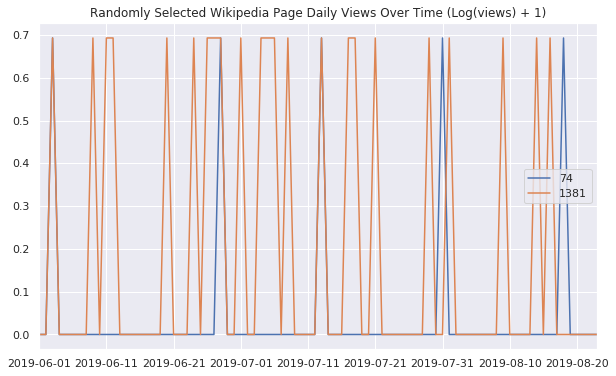

In [144]:
def plot_random_series(df, n_series):
    
    sample = df.sample(n_series, random_state=8)
    page_labels = sample['num'].tolist()
    series_samples = sample.loc[:,data_start_date:data_end_date]
    
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        np.log1p(pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
    
    plt.title('Randomly Selected Wikipedia Page Daily Views Over Time (Log(views) + 1)')
    plt.legend(page_labels)
    
plot_random_series(df, 2)

## 2. Formatting the Data for Modeling 

Sadly we can't just throw the dataframe we've created into keras and let it work its magic. Instead, we have to set up a few data transformation steps to extract nice numpy arrays that we can pass to keras. But even before doing that, we have to know how to appropriately partition the time series into encoding and prediction intervals for the purposes of training and validation. Note that for our simple convolutional model we won't use an encoder-decoder architecture like in the first notebook, but **we'll keep the "encoding" and "decoding" (prediction) terminology to be consistent** -- in this case, the encoding interval represents the entire series history that we will use for the network's feature learning, but not output any predictions on. 

We'll use a style of **walk-forward validation**, where our validation set spans the same time-range as our training set, but shifted forward in time (in this case by 60 days). This way, we simulate how our model will perform on unseen data that comes in the future. 

[Artur Suilin](https://github.com/Arturus/kaggle-web-traffic/blob/master/how_it_works.md) has created a very nice image that visualizes this validation style and contrasts it with traditional validation. I highly recommend checking out his entire repo, as he's implemented a truly state of the art (and competition winning) seq2seq model on this data set. 

![architecture](images/ArturSuilin_validation.png)

### Train and Validation Series Partioning

We need to create 4 sub-segments of the data:

    1. Train encoding period
    2. Train decoding period (train targets, 60 days)
    3. Validation encoding period
    4. Validation decoding period (validation targets, 60 days)
    
We'll do this by finding the appropriate start and end dates for each segment. Starting from the end of the data we've loaded, we'll work backwards to get validation and training prediction intervals. Then we'll work forward from the start to get training and validation encoding intervals. 

In [145]:
from datetime import timedelta

pred_steps = 28
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

pred_28_start = last_day + timedelta(1)
pred_28_end = pred_28_start + pred_length

val_pred_start = last_day - timedelta(7*4) + timedelta(1)
val_pred_end = last_day

train_pred_start = last_day - timedelta(7*8) + timedelta(1)
train_pred_end = last_day - timedelta(7*4) 

enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_pred_start - timedelta(1)

val_enc_end = val_pred_start - timedelta(1)
val_enc_start = first_day

pred_28_enc_start = first_day
pred_28_enc_end = last_day

print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)
print('\nEncoding interval:', enc_length)
print('Prediction interval:', pred_length)
print('pred_28_encoding:', pred_28_enc_start, '-', pred_28_enc_end)
print('pred_28_Prediction:', pred_28_start, '-', pred_28_end)

Train encoding: 2019-06-01 00:00:00 - 2019-06-28 00:00:00
Train prediction: 2019-06-29 00:00:00 - 2019-07-26 00:00:00 

Val encoding: 2019-06-01 00:00:00 - 2019-07-26 00:00:00
Val prediction: 2019-07-27 00:00:00 - 2019-08-23 00:00:00

Encoding interval: 28 days 00:00:00
Prediction interval: 28 days, 0:00:00
pred_28_encoding: 2019-06-01 00:00:00 - 2019-08-23 00:00:00
pred_28_Prediction: 2019-08-24 00:00:00 - 2019-09-21 00:00:00


### Keras Data Formatting

Now that we have the time segment dates, we'll define the functions we need to extract the data in keras friendly format. Here are the steps:

* Pull the time series into an array, save a date_to_index mapping as a utility for referencing into the array 
* Create function to extract specified time interval from all the series 
* Create functions to transform all the series. 
    - Here we smooth out the scale by taking log1p and de-meaning each series using the encoder series mean, then reshape to the **(n_series, n_timesteps, n_features) tensor format** that keras will expect. 
    - Note that if we want to generate true predictions instead of log scale ones, we can easily apply a reverse transformation at prediction time. 

In [146]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])
print(date_to_index)
series_array = df[df.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array
print(series_array)

2019-06-01     0
2019-06-02     1
2019-06-03     2
2019-06-04     3
2019-06-05     4
              ..
2019-08-19    79
2019-08-20    80
2019-08-21    81
2019-08-22    82
2019-08-23    83
Length: 84, dtype: int64
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## 3. Building the Model - Architecture

This convolutional architecture is a full-fledged version of the [WaveNet model](https://deepmind.com/blog/wavenet-generative-model-raw-audio/), designed as a generative model for audio (in particular, for text-to-speech applications). The wavenet model can be abstracted beyond audio to apply to any time series forecasting problem, providing a nice structure for capturing long-term dependencies without an excessive number of learned weights.

The core building block of the wavenet model is the **dilated causal convolution layer**, discussed in detail in the [previous notebook of this series](https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Intro.ipynb) as well as the [accompanying blog post](https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv/). In summary, this style of convolution properly handles temporal flow and allows the receptive field of outputs to increase exponentially as a function of the number of layers. This structure is nicely visualized by the below diagram from the wavenet paper. 

![dilatedconv](images/WaveNet_dilatedconv.png)

The model also utilizes some other key techniques: **gated activations**, **residual connections**, and **skip connections**. I'll introduce and explain these techniques, then show how to implement our full-fledged WaveNet architecture in keras. The WaveNet paper diagram below details how the model's components fit together block by block into a stack of operations, so we'll use it as a handy reference as we go (note that there are slight discrepancies between the diagram and what we implement, e.g. the original WaveNet has a softmax classification rather than regression output).   

![blocks](images/WaveNet_residblock.png)

### **Gated Activations**

In the boxed portion of the architecture diagram, you'll notice that the dilated convolution output splits into two branches that are later recombined via element-wise multiplication. This depicts a *gated activation unit*, where we interpret the *tanh* activation branch as a learned filter and the *sigmoid* activation branch as a learned gate that regulates the information flow from the filter. If this reminds you of the gating mechanisms used in [LSTMs or GRUs](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) you're on point, as those models use the same style of information gating to control adjustments to their cell states.

In mathematical notation, this means we map a convolutional block's input $x$ to output $z$ via the below, where $W_f$ and $W_g$ correspond to (learned) dilated causal convolution weights:

$$ z = tanh(W_f * x) \odot \sigma(W_g * x) $$

Why use gated activations instead of the more standard *ReLU* activation? The WaveNet designers found that gated activations saw stronger performance empirically than ReLU activations for audio data, and this outperformance may extend broadly to time series data. Perhaps the [sparsity induced by ReLU activations](http://proceedings.mlr.press/v15/glorot11a.html) is not as well suited to time series forecasting as it is to other problem domains, or gated activations allow for smoother information (gradient) flow over a many-layered WaveNet architecture. However, this choice of activation is certainly not set in stone and I'd be interested to see a results comparison when trying ReLU instead. With that caveat, we'll be sticking with the gated activations in the interest of learning about the full original architecture.            

### **Residual and Skip Connections**

In traditional neural network architectures, a neuron layer takes direct input only from the layer that precedes it, so early layers influence deeper layers via a heirarchy of intermediate computations. In theory, this heirarchy allows the network to properly build up high-level predictive features off of lower-level/raw signals. For example, in image classification problems, neural nets start from raw pixel values, find generic geometric and textural patterns, then combine these generic patterns to construct fine-grained representations of the features that identify specific object types.

But what if lower-level signals are actually immediately useful for prediction, and may be at risk of distortion as they're passed through a complex heirarchy of computations? We could always simplify the heirarchy by using fewer layers and units, but what if we want the best of both worlds: direct, unfiltered low-level signals and nuanced heirarchical representations? One avenue for addressing this problem is provided by **skip connections**, which act to preserve earlier feature layer outputs as the network passes forward signals for final prediction processing. To build intuition for why we would want a mix of feature complexities in our problem domain, consider the wide range of time series drivers - there are strong and direct autoregressive components, moderately more sophisticated trend and seasonality components, and idiosyncratic trajectories that are difficult to spot with the human eye.        

To leverage skip connections, we can simply store the tensor output of each convolutional block in addition to passing it through further blocks (or choose select blocks to store output from). At the end of the block heirarchy, we then have a collection of feature outputs at *all levels of the heirarchy*, rather than a singular set of maximally complex feature outputs. This collection of outputs is then combined for final processing, typically via concatenation or addition (we'll use the latter).

With this in mind, return to the WaveNet block diagram above, and notice how for each block in the stack, the post-convolution gated activations pass through to the set of skip connections. This visualizes the tensor output storage and eventual combination just described. Note that the frequency and structure of skip connections is fully customizable and can be chosen experimentally and via domain expertise - as an example of an alternate skip connection structure, check out this convolutional architecture from a [semantic segmentation paper](https://www.researchgate.net/publication/327330378_Semantic_Segmentation_Based_on_Deep_Convolution_Neural_Network).

![CNN_skips](images/CNN_skips.png)

**Residual connections** are closely related to skip connections; in fact, they can be viewed as specialized, short skips further into the network (often and in our case just one layer). With residual connections, we think of mapping a network block's input to output via $x_{out} = f(x_{in}) + x_{in}$ instead of using the traditional direct mapping $x_{out} = f(x_{in})$, for some function $f$ that corresponds to the model's learned weights. This helps allow for the possibility that the model learns a mapping that acts almost as an identity function, with the input passing through nearly unchanged. In the diagram above, such connections are visualized by the rounded arrows grouped with each pair of convolutions.  

Why would this be beneficial? Well, the effectiveness of residual connections is still not fully understood, but a compelling explanation is that they facilitate the use of deeper networks by allowing for more direct gradient flow in backpropagation. It's often difficult to efficienctly train the early layers of a deep network due to the length of the backpropagation chain, but residual and skip connections create an easier information highway. Intuitively, perhaps you can think of both as mechanisms for guarding against overcomputation and intermediate signal loss. You can check out the [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf) that originated the residual connection concept for more discussion and empirical results.

Though our architecture will be shallower than the original WaveNet (fewer convolutional blocks), we'll likely still see some benefit from introducing skip and residual connections at every block. Returning to the WaveNet architecture diagram again, you can see how the residual connection allows each block's input to bypass the convolution stage, and then adds that input to the convolution output. A final point to note is that the diagram's *1x1 convolutions* are really just equivalent to (time-distributed) fully connected layers, and serve in post-processing and standardization capacities. Our setup will use layers of this style (with different filter dimensions) for **post/pre-processing** to facilitate our skip and residual connections, as well as for generating final prediction outputs.           

### **Our Architecture**

With all of our components now laid out, here's what we'll use:

* 16 dilated causal convolutional blocks
    * Preprocessing and postprocessing (time distributed) fully connected layers (convolutions with filter width 1): 16 output units
    * 32 filters of width 2 per block
    * Exponentially increasing dilation rate with a reset (1, 2, 4, 8, ..., 128, 1, 2, ..., 128) 
    * Gated activations
    * Residual and skip connections
* 2 (time distributed) fully connected layers to map sum of skip outputs to final output 

We'll extract the last 60 steps from the output sequence as our predicted output for training. We'll use teacher forcing again during training. Similarly to the previous notebook, we'll have a separate function that runs an inference loop to generate predictions on unseen data, iteratively filling previous predictions into the history sequence (section 4). 

In [0]:
#from keras.models import Model
#from keras.layers import Conv1D, Activation, Dropout, Lambda, Multiply, Add, Concatenate, Input, Dense 
#from keras.optimizers import Adam

from tensorflow.python.keras.layers import Input, Dense, Conv1D, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.optimizers import Adam

# convolutional operation parameters
n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2 

# define an input history series and pass it through a stack of dilated causal convolution blocks. 
history_seq = Input(shape=(None, 1))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)

# extract the last 60 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':28})(out)#60

model = Model(history_seq, pred_seq_train)
model.compile(Adam(), loss='mean_absolute_error')

In [148]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_198 (Conv1D)             (None, None, 16)     32          input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_199 (Conv1D)             (None, None, 32)     1056        conv1d_198[0][0]                 
__________________________________________________________________________________________________
conv1d_200 (Conv1D)             (None, None, 32)     1056        conv1d_198[0][0]                 
____________________________________________________________________________________________

With our training architecture defined, we're ready to train the model! This will take quite a while if you're not running fancy hardware (read GPU). We'll leverage the transformer utility functions we defined earlier, and train using mean absolute error loss.

Note that for this full-fledged model, we have more than twice as many total parameters to train as we did with the simpler WaveNet model, explaining the slower training time (along with using more training data). From the loss curve you'll see plotted below, it also seems likely that the model can continue to improve with more than 10 training epochs -- the more complex model probably needs additional time to reach its full potential. That said, from the results plots (see section 5) we can see that this full-fledged model is very capable of handling the 60-day forecast horizon and often can generate very expressive predictions. 

This is only a starting point, and I would encourage you to play around with this architecture to see if you can get even better results! You could try using more data, adjusting the hyperparameters, tuning the learning rate and number of epochs, etc.  

In [149]:
first_n_samples = 1440
batch_size = 8
epochs = 50

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, train_pred_start, train_pred_end)[:first_n_samples]
print('decoder_target_data =')
print(decoder_target_data[400:410])
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)
print('decoder_target_data =')
print(decoder_target_data[400:410])

decoder_target_data =
[[0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
decoder_target_data =
[[[-0.12377628]
  [-0.12377628]
  [ 0.5693709 ]
  [ 0.5693709 ]
  [-0.12377628]
  [-0.12377628]
  [-0.12377628]
  [-0.12377628]
  [-0.12377628]
  [-0.12377628]
  [-0.12377628]
  [-0.12377628]
  [-0.12377628]
  [-0.12377628]
  [-0.12377628]
  [-0.12377628]
  [-0.12377628]
  [-0.12377628]
  [-0.12377628]
  [-0.12377628]
  [-0.12377628]
  [-0.12377628]
  [-0.1237762

In [150]:
# we append a lagged history of the target series to the input data, 
# so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)
model.compile(Adam(), loss='mean_absolute_error')
print("encoder_input_data")
print(encoder_input_data.shape)
print("decoder_target_data")
print(decoder_target_data.shape)

encoder_input_data
(1440, 55, 1)
decoder_target_data
(1440, 28, 1)


In [151]:
history = model.fit(encoder_input_data, decoder_target_data, batch_size=batch_size, epochs=epochs, validation_split=0.4)  

Train on 864 samples, validate on 576 samples
Epoch 1/50
864/864 [==============================] - 18s 21ms/sample - loss: 0.1580 - val_loss: 0.2612
Epoch 2/50
864/864 [==============================] - 6s 7ms/sample - loss: 0.1509 - val_loss: 0.2543
Epoch 3/50
864/864 [==============================] - 6s 7ms/sample - loss: 0.1497 - val_loss: 0.2520
Epoch 4/50
864/864 [==============================] - 6s 7ms/sample - loss: 0.1485 - val_loss: 0.2499
Epoch 5/50
864/864 [==============================] - 6s 7ms/sample - loss: 0.1482 - val_loss: 0.2508
Epoch 6/50
864/864 [==============================] - 6s 8ms/sample - loss: 0.1476 - val_loss: 0.2557
Epoch 7/50
864/864 [==============================] - 6s 7ms/sample - loss: 0.1471 - val_loss: 0.2496
Epoch 8/50
864/864 [==============================] - 6s 7ms/sample - loss: 0.1475 - val_loss: 0.2546
Epoch 9/50
864/864 [==============================] - 6s 7ms/sample - loss: 0.1477 - val_loss: 0.2569
Epoch 10/50
864/864 [=============

It's typically a good idea to look at the convergence curve of train/validation loss.

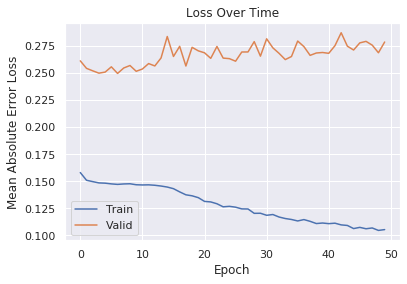

In [152]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

## 4. Building the Model - Inference Loop

Like in the previous notebook, we'll generate predictions by running our model from section 3 in a loop, using each iteration to extract the prediction for the time step one beyond our current history then append it to our history sequence. With 60 iterations, this lets us generate predictions for the full interval we've chosen. 

Recall that we designed our model to output predictions for 60 time steps at once in order to use teacher forcing for training. So if we start from a history sequence and want to predict the first future time step, we can run the model on the history sequence and take the last time step of the output, which corresponds to one time step beyond the history sequence. 

In [0]:
def predict_sequence(input_sequence):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,1,1)], axis=1)

    return pred_sequence

## 5. Generating and Plotting Predictions 

Now we have everything we need to generate predictions for encoder (history) /target series pairs that we didn't train on (note again we're using "encoder"/"decoder" terminology to stay consistent with notebook 1 -- here it's more like history/target). We'll pull out our set of validation encoder/target series (recall that these are shifted forward in time). Then using a plotting utility function, we can look at the tail end of the encoder series, the true target series, and the predicted target series. This gives us a feel for how our predictions are doing.  

In [0]:
encoder_input_data = get_time_block_series(series_array, date_to_index, pred_28_enc_start, pred_28_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

#decoder_target_data = get_time_block_series(series_array, date_to_index, pred_28_start, pred_28_end)
#decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [0]:
def predict_and_plot1(encoder_input_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = predict_sequence(encode_series)

    return pred_series

In [0]:
import math
import csv

file_name = '/content/drive/Shared drives/Me/TimeSeries_Seq2Seq/pre_28_11111.csv'
tmp2 = open(file_name, 'w',newline='',encoding="utf-8") # a表示在最后一行后面追加

csv_write = csv.writer(tmp2)
#pop = ['num','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28']
#csv_write.writerow(pop)

for i in range(0,1440):
    pop = []
    pred_series = predict_and_plot1(encoder_input_data, sample_ind=i, enc_tail_len=100)
    pop.append(i)
    #print(pred_series)
    for k in range(0,28):
        #print(pred_series[0][k][0])
        if pred_series[0][k][0] >= 0.2:
            pop.append(1)
        else:   
            pop.append(0)
        #pop.append(pred_series[0][k][0])
    csv_write.writerow(pop)
tmp2.close()  



In [0]:
def predict_sequence(input_sequence):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(28):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,1,1)], axis=1)

    return pred_sequence

In [0]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [0]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = predict_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

Generating some plots as below, we can see that our longer time horizon predictions (60 days) are often strong and expressive. Our full-fledged model is able to effectively capture weekly seasonality patterns and long term trends, and does a very nice job adapting to the varying levels of fluctuation in each series.   

Still, we can do even better! We'd benefit from increasing the sample size for training and fine-tuning our hyperparameters, but also by giving the model access to additional relevant information. So far we've only fed the model raw time series data, but it can likely benefit from the inclusion of **exogenous variables** such as the day of the week and the language of the webpage corresponding to each series. To see how these exogenous variables can be incorporated directly into the model **check out the next notebook in this series**. 

If you're interested in digging even deeper into state of the art WaveNet style architectures, I also highly recommend checking out [Sean Vasquez's model](https://github.com/sjvasquez/web-traffic-forecasting) that was designed for this data set. He implements a customized seq2seq WaveNet architecture in tensorflow.    

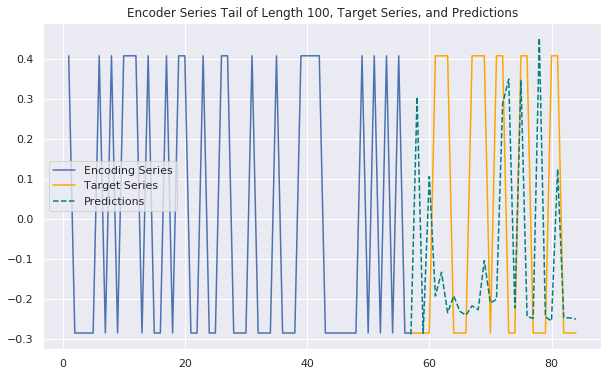

In [160]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=710, enc_tail_len=100)

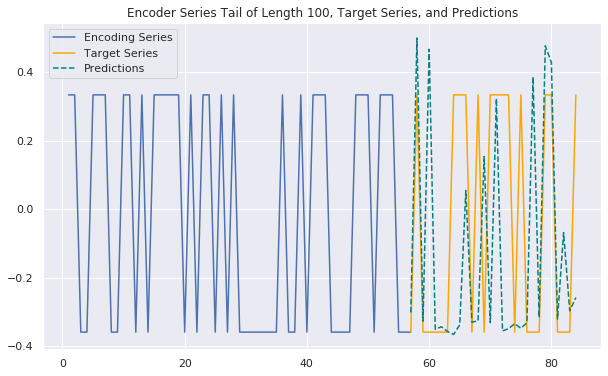

In [161]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=555, enc_tail_len=100)

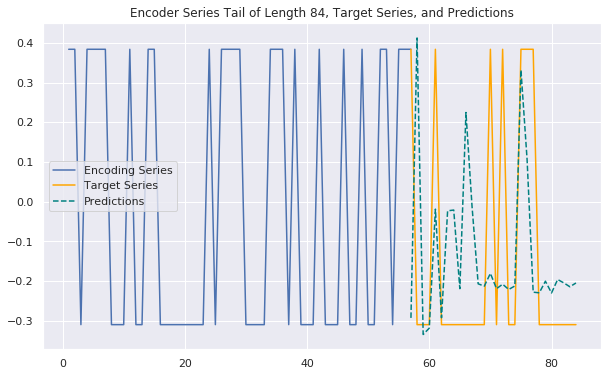

In [162]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=1200, enc_tail_len=84)

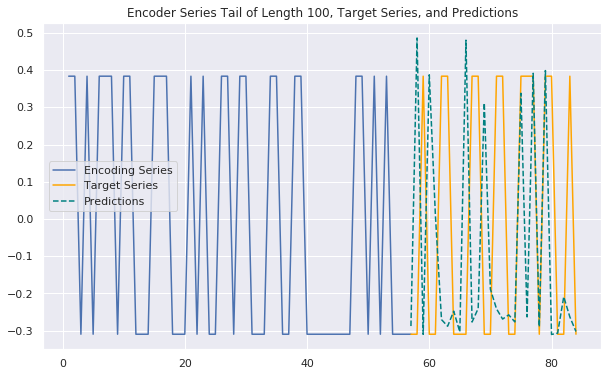

In [163]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=680, enc_tail_len=100)

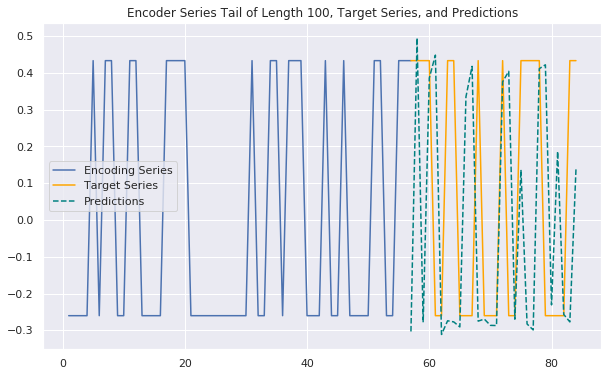

In [164]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=1007, enc_tail_len=100)

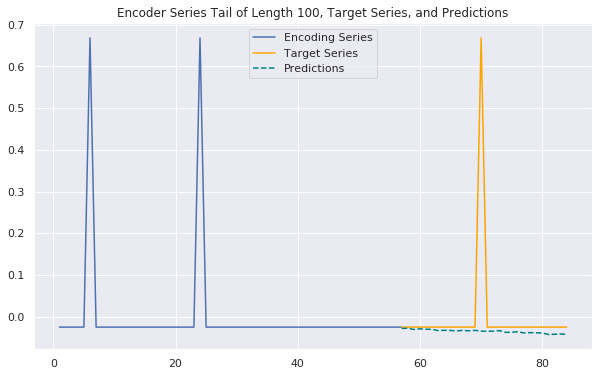

In [165]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=1439, enc_tail_len=100)

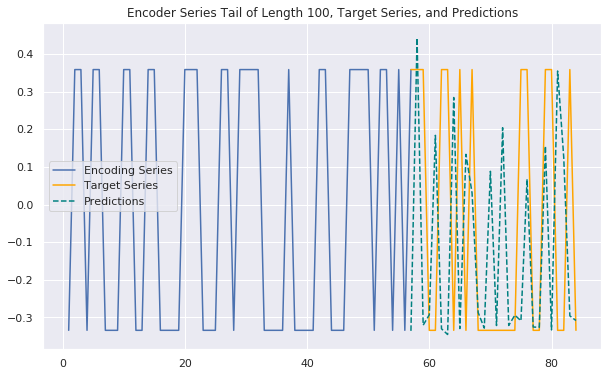

In [166]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=1300, enc_tail_len=100)